In [1]:
#comment out if not using colab
#from google.colab import files
#uploaded = files.upload()

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam

In [3]:
filename='datasets/pre_data_dl.csv'
data_dl=pd.read_csv(filename)
#pd.set_option('display.max_columns', None)
print(data_dl.head())
filename1='datasets/pre_data_dl_aug1.csv'
filename2='datasets/pre_data_dl_aug2.csv'
data_dl_aug1=pd.read_csv(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())
data_dl_aug2=pd.read_csv(filename2)
print(data_dl_aug2.head())


   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [4]:
X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

In [5]:
#parameters
max_features=10000
emb_dim=300
batch_size=1024
epochs=10

In [6]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

vocabulary size is:  3316


In [7]:
#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')

In [8]:
#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


In [9]:
#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.01, 
    mode='max'
)

In [10]:
#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title(modelname + ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 
inp_len=X.shape[1]
print(inp_len)

189


In [11]:
#Simple LSTM model
def LSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model
 
#Using GRU
def GRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model    

#BILSTM
def BILSTM_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model

#Using bidirectional GRU
def BIGRU_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model

#using transformer(no of layers in transfomers have been reduce as the total number of parameters reaches close to 400 million when using 512 layers)
def TRANSFORMER_model(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(128, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(max_features))
 model.add(Bidirectional(LSTM(128, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 128, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model


In [12]:
#customising the kerastuner function to include batch size and epochs
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 256, 512,step=256 )
     kwargs['epochs'] = trial.hyperparameters.Int('epochs', 5, 10,20)
     super(MyTuner, self).run_trial(trial, *args, **kwargs)

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/1/untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 189, 512)          1665024   
_________________________________________________________________
dropout (Dropout)            (None, 189, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 96768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7160906   
Total params: 12,0

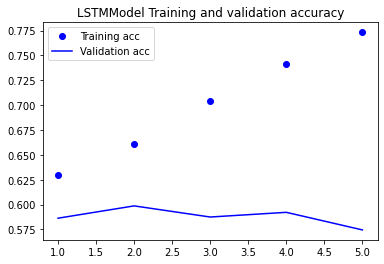

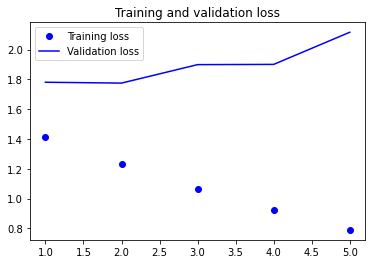

Accuracy of LSTM for unaugmented data is : 57.4543297290802
Validation Accuracy of LSTM for unagumented data is: 79.48113083839417
Mean loss of  Validation data of LSTM for unaugmented data is : 1.8945934772491455
Mean loss of  Training data of LSTM for unaugmented data is : 1.085810613632202


In [14]:
tuner =MyTuner(
    LSTM_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/1"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM =best_model_LSTM.evaluate(X_test, y_test, verbose=0)
scores_LSTM_val = best_model_LSTM.evaluate(X_train, y_train, verbose=0)
print("Accuracy of LSTM for unaugmented data is :", (scores_LSTM[1]*100))
print("Validation Accuracy of LSTM for unagumented data is:", (scores_LSTM_val[1]*100))
#print("Validation Accuracy of LSTM for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of LSTM for unaugmented data is :",np.array(history.history['loss']).mean())

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/2/untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
gru (GRU)                    (None, 189, 512)          1250304   
_________________________________________________________________
dropout (Dropout)            (None, 189, 512)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 512)          262656    
_________________________________________________________________
flatten (Flatten)            (None, 96768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7160906   
Total params: 11,6

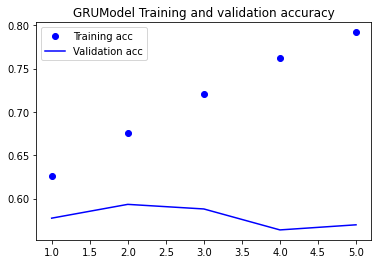

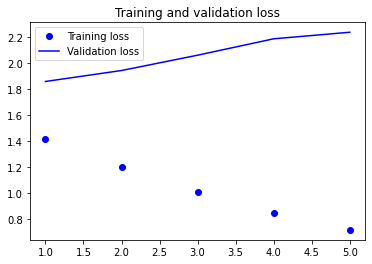

Accuracy of GRU for unaugmented data is : 56.98291063308716
Validation Accuracy of GRU for unagumented data is: 82.10495114326477
Mean loss of  Validation data of GRU for unaugmented data is : 2.054730176925659
Mean loss of  Training data of GRU for unaugmented data is : 1.0393791794776917


In [15]:
tuner =MyTuner(
    GRU_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/2"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU =best_model_GRU.evaluate(X_test, y_test, verbose=0)
scores_GRU_val = best_model_GRU.evaluate(X_train, y_train, verbose=0)
print("Accuracy of GRU for unaugmented data is :", (scores_GRU[1]*100))
print("Validation Accuracy of GRU for unagumented data is:", (scores_GRU_val[1]*100))
#print("Validation Accuracy of GRU for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of GRU for unaugmented data is :",np.array(history.history['loss']).mean())


INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/3/untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 189, 1024)         3330048   
_________________________________________________________________
dropout (Dropout)            (None, 189, 1024)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 512)          524800    
_________________________________________________________________
flatten (Flatten)            (None, 96768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7160906   
Total params: 14,0

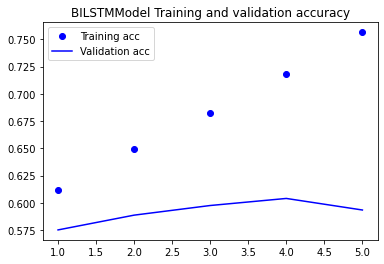

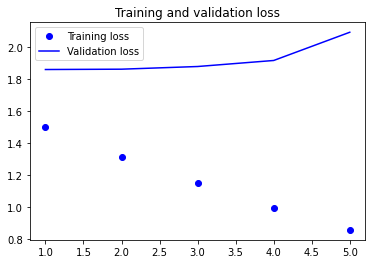

Accuracy of BILSTM for unaugmented data is : 59.340012073516846
Validation Accuracy of BILSTM for unagumented data is: 78.68514060974121
Mean loss of  Validation data of BILSTM for unaugmented data is : 1.922223973274231
Mean loss of  Training data of BILSTM for unaugmented data is : 1.1643295288085938


In [16]:
tuner =MyTuner(
    BILSTM_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/3"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM =best_model_BILSTM.evaluate(X_test, y_test, verbose=0)
scores_BILSTM_val = best_model_BILSTM.evaluate(X_train, y_train, verbose=0)
print("Accuracy of BILSTM for unaugmented data is :", (scores_BILSTM[1]*100))
print("Validation Accuracy of BILSTM for unagumented data is:", (scores_BILSTM_val[1]*100))
#print("Validation Accuracy of BILSTM for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BILSTM for unaugmented data is :",np.array(history.history['loss']).mean())


INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/4/untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 189, 1024)         2500608   
_________________________________________________________________
dropout (Dropout)            (None, 189, 1024)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 512)          524800    
_________________________________________________________________
flatten (Flatten)            (None, 96768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                7160906   
Total params: 13,1

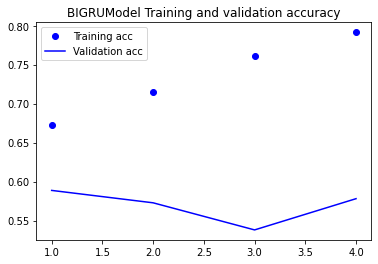

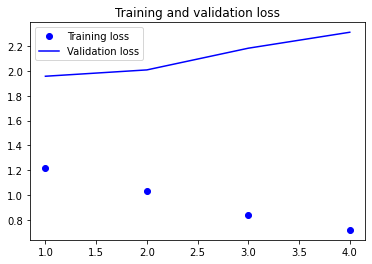

Accuracy of BIGRU for unaugmented data is : 57.80789852142334
Validation Accuracy of BIGRU for unagumented data is: 83.56426954269409
Mean loss of  Validation data of BIGRU for unaugmented data is : 2.115270972251892
Mean loss of  Training data of BIGRU for unaugmented data is : 0.9517049640417099


In [17]:
tuner =MyTuner(
    BIGRU_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/4"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU =best_model_BIGRU.evaluate(X_test, y_test, verbose=0)
scores_BIGRU_val = best_model_BIGRU.evaluate(X_train, y_train, verbose=0)
print("Accuracy of BIGRU for unaugmented data is :", (scores_BIGRU[1]*100))
print("Validation Accuracy of BIGRU for unagumented data is:", (scores_BIGRU_val[1]*100))
#print("Validation Accuracy of BIGRU for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of BIGRU for unaugmented data is :",np.array(history.history['loss']).mean())

In [18]:
tuner =MyTuner(
    TRANSFORMER_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/4A"
)

tuner.search(X_train,y_train,validation_data=(X_test,y_test))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train,y_train,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER =best_model_TRANSFORMER.evaluate(X_test, y_test, verbose=0)
scores_TRANSFORMER_val = best_model_TRANSFORMER.evaluate(X_train, y_train, verbose=0)
print("Accuracy of TRANSFORMER for unaugmented data is :", (scores_TRANSFORMER[1]*100))
print("Validation Accuracy of TRANSFORMER for unagumented data is:", (scores_TRANSFORMER_val[1]*100))
#print("Validation Accuracy of TRANSFORMER for unagumented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of TRANSFORMER for unaugmented data is :",np.array(history.history['loss']).mean())

INFO:tensorflow:Reloading Oracle from existing project C:/Hyperparameter/4A/untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10000, 256)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10000, 256)        394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 10000, 128)        32896     
_________________

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Adam/Adam/update/AssignSubVariableOp/_39}}]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_36]] [Op:__inference_train_function_45002]

Function call stack:
train_function


In [ ]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])
  

In [ ]:
#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

In [ ]:
#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

In [ ]:
#split the data.Only augmented data is split using stratify
def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
print(inp_len1)

In [ ]:
#Simple LSTM model1
def LSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(LSTM(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model



#Using GRU
def GRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(GRU(512, return_sequences=True))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


 #Using bidirectional LSTM

def BILSTM_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


#Using bidirectional GRU
def BIGRU_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(GRU(512, return_sequences=True)))
 model.add(Dropout(0.2))
 model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
 model.compile(optimizer=Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 return model


#using transformer(no of layers in transfomers have been reduce as the total number of parameters reaches close to 400 million when using 512 layers)
def TRANSFORMER_model1(hp):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(128, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(max_features))
 model.add(Bidirectional(LSTM(128, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 128, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])   
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

In [ ]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/5"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM_aug1 =best_model_LSTM.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_LSTM_val_aug1 = best_model_LSTM.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of LSTM for level1 augmented data is :", (scores_LSTM_aug1[1]*100))
print("Validation Accuracy of LSTM for level1 augmented data is:", (scores_LSTM_val_aug1[1]*100))
#print("Validation Accuracy of LSTM for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level1 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/6"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU_aug1 =best_model_GRU.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_GRU_val_aug1 = best_model_GRU.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of GRU for level1 augmented data is :", (scores_GRU_aug1[1]*100))
print("Validation Accuracy of GRU for level1 augmented data is:", (scores_GRU_val_aug1[1]*100))
#print("Validation Accuracy of GRU for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level1 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/7"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM_aug1 =best_model_BILSTM.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_BILSTM_val_aug1 = best_model_BILSTM.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of BILSTM for level1 augmented data is :", (scores_BILSTM_aug1[1]*100))
print("Validation Accuracy of BILSTM for level1 augmented  data is:", (scores_BILSTM_val_aug1[1]*100))
#print("Validation Accuracy of BILSTM forlevel1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level1 augmented data is :",np.array(history.history['loss']).mean())


In [ ]:
tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/8"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU_aug1 =best_model_BIGRU.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_BIGRU_val_aug1 = best_model_BIGRU.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of BIGRU for level1 augmented data is :", (scores_BIGRU_aug1[1]*100))
print("Validation Accuracy of BIGRU for level1 augmented data is:", (scores_BIGRU_val_aug1[1]*100))
#print("Validation Accuracy of BIGRU for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level1 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    TRANSFORMER_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/8A"
)

tuner.search(X_train_aug1,y_train_aug1,validation_data=(X_test_aug1,y_test_aug1))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel_aug1"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train_aug1,y_train_aug1,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER_aug1 =best_model_TRANSFORMER.evaluate(X_test_aug1, y_test_aug1, verbose=0)
scores_TRANSFORMER_val_aug1 = best_model_TRANSFORMER.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of TRANSFORMER for level1 augmented data is :", (scores_TRANSFORMER_aug1[1]*100))
print("Validation Accuracy of TRANSFORMER for level1 augmented data is:", (scores_TRANSFORMER_val_aug1[1]*100))
#print("Validation Accuracy of TRANSFORMER for level1 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level1 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    LSTM_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/9"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_LSTM = tuner.get_best_models()[0]
print("Hyperparameters for LSTM are",best_model_LSTM)


modelname="LSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_LSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_LSTM,history)

scores_LSTM_aug2 =best_model_LSTM.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_LSTM_val_aug2 = best_model_LSTM.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of LSTM for level2 augmented data is :", (scores_LSTM_aug2[1]*100))
print("Validation Accuracy of LSTM for level2 augmented data is:", (scores_LSTM_val_aug2[1]*100))
#print("Validation Accuracy of LSTM for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of LSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of LSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    GRU_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/10"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_GRU = tuner.get_best_models()[0]
print("Hyperparameters for GRU are",best_model_GRU)


modelname="GRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_GRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_GRU,history)

scores_GRU_aug2 =best_model_GRU.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_GRU_val_aug2 = best_model_GRU.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of GRU for level2 augmented data is :", (scores_GRU_aug2[1]*100))
print("Validation Accuracy of GRU for level2 augmented data is:", (scores_GRU_val_aug2[1]*100))
#print("Validation Accuracy of GRU for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of GRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of GRU for level2 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    BILSTM_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/11"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BILSTM = tuner.get_best_models()[0]
print("Hyperparameters for BILSTM are",best_model_BILSTM)


modelname="BILSTMModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BILSTM.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BILSTM,history)

scores_BILSTM_aug2 =best_model_BILSTM.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_BILSTM_val_aug2 = best_model_BILSTM.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of BILSTM for level2 augmented data is :", (scores_BILSTM_aug2[1]*100))
print("Validation Accuracy of BILSTM for level2 augmented  data is:", (scores_BILSTM_val_aug2[1]*100))
#print("Validation Accuracy of BILSTM forlevel2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BILSTM for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BILSTM for level2 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    BIGRU_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/12"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_BIGRU = tuner.get_best_models()[0]
print("Hyperparameters for BIGRU are",best_model_BIGRU)


modelname="BIGRUModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_BIGRU.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_BIGRU,history)

scores_BIGRU_aug2 =best_model_BIGRU.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_BIGRU_val_aug2 = best_model_BIGRU.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of BIGRU for level2 augmented data is :", (scores_BIGRU_aug2[1]*100))
print("Validation Accuracy of BIGRU for level2 augmented data is:", (scores_BIGRU_val_aug2[1]*100))
#print("Validation Accuracy of BIGRU for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of BIGRU for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of BIGRU for level2 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
tuner =MyTuner(
    TRANSFORMER_model1,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    seed=123,
    directory="C:/Hyperparameter/12A"
)

tuner.search(X_train_aug2,y_train_aug2,validation_data=(X_test_aug2,y_test_aug2))
print(tuner.results_summary(5))
best_model_TRANSFORMER = tuner.get_best_models()[0]
print("Hyperparameters for TRANSFORMER are",best_model_TRANSFORMER)


modelname="TRANSFORMERModel_aug2"
vals=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(vals)
batch_size_hyp=list(vals.values())[1]
epochs_hyp=list(vals.values())[2]
history=best_model_TRANSFORMER.fit(X_train_aug2,y_train_aug2,batch_size=batch_size_hyp,epochs=epochs_hyp,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(best_model_TRANSFORMER,history)

scores_TRANSFORMER_aug2 =best_model_TRANSFORMER.evaluate(X_test_aug2, y_test_aug2, verbose=0)
scores_TRANSFORMER_val_aug2 = best_model_TRANSFORMER.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of TRANSFORMER for level2 augmented data is :", (scores_TRANSFORMER_aug2[1]*100))
print("Validation Accuracy of TRANSFORMER for level2 augmented data is:", (scores_TRANSFORMER_val_aug2[1]*100))
#print("Validation Accuracy of TRANSFORMER for level2 augmented data is:" ,np.array(history.history['val_acc']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level2 augmented data is :",np.array(history.history['loss']).mean())

In [ ]:
print("Accuracy of LSTM with hyperparameter tuning for unagumented data is:", (scores_LSTM[1]*100))
print("Accuracy of GRU with hyperparameter tuning for unagumented data is:",  (scores_GRU[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning unagumented data is:", (scores_BILSTM[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning unagumented data is:", (scores_BIGRU[1]*100))
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning unagumented data is:", (scores_TRANSFORMER[1]*100))

print("Accuracy of LSTM with hyperparameter tuning for level1 augmentation data is:", (scores_LSTM_aug1[1]*100))
print("Accuracy of GRU with hyperparameter tuning for level1 augmentation data is:", (scores_GRU_aug1[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning for level1 augmentation data is:", (scores_BILSTM_aug1[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning for level1 augmentation data is:", (scores_BIGRU_aug1[1]*100))
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level1 augmentation data is:", (scores_TRANSFORMER_aug1[1]*100))


print("Accuracy of LSTM with hyperparameter tuning for level2 augmentation data is:", (scores_LSTM_aug2[1]*100))
print("Accuracy of GRU with hyperparameter tuning for level2 augmentation data is:", (scores_GRU_aug2[1]*100))
print("Accuracy of BILSTM with hyperparameter tuning for level2 augmentation data is:", (scores_BILSTM_aug2[1]*100))
print("Accuracy of BIGRU with hyperparameter tuning for level2 augmentation data is:", (scores_BIGRU_aug2[1]*100))
print("Accuracy of ENCODER DECODER without attention with hyperparameter tuning for level2 augmentation data is:", (scores_TRANSFORMER_aug2[1]*100))
